## Get Exact Coordinates

This notebook processes the bounding boxes predicted from YOLO and gets the exact location (lat, lon) of brick kilns in the image.

Some information:
* filenames are in the format: `{lat},{lon}.txt` where lat and lon are central coordinates of the image sized 1120x1120 pixels.
* `project` and `inverse_project` are inspired from: https://gis.stackexchange.com/a/279234 and a JS code given by Google here: https://developers.google.com/maps/documentation/javascript/examples/map-coordinates

In [1]:
import os
import scipy
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from haversine import haversine, haversine_vector
from torchvision.ops import box_iou
import xarray as xr
from einops import rearrange
import torch

In [2]:
class_map = {"0": "zigzag", "1": "fcbk"}
states = ["punjab", "haryana", "bihar", "jharkhand", "madhya_pradesh", "west_bengal", "uttar_pradesh", "himachal_pradesh", "uttarakhand", "bangladesh"]
state = states[-1]
print(f"State: {state}")
image_size = 1120
read_dir = "/home/patel_zeel/compass24/corrected_txt"
save_dir = "/home/patel_zeel/compass24/exact_latlon"

State: bangladesh


In [3]:
def project(lat,lon):
    lat = np.radians(lat)
    lon = np.radians(lon)
    x = (128/np.pi)*(2**17)*(lon + np.pi)
    y = (128/np.pi)*(2**17)*(np.pi - np.log(np.tan(np.pi/4 + lat/2)))
    return x,y

def inverse_project(x,y):
    F  = 128 / np.pi * 2 ** 17
    lon = (x / F) - np.pi
    lat = (2 * np.arctan(np.exp(np.pi - y/F)) - np.pi / 2)
    lon = lon * 180 / np.pi
    lat = lat * 180 / np.pi
    return lat, lon

def process_file(path):
    file_name = path.split("/")[-1].rsplit(".",1)[0]
    center_lat, center_lon = map(float,file_name.split(","))
    
    with open(path) as f:
        lines = f.readlines()
        
    result = []
    for line_id, line in enumerate(lines):
        elements = line.split()
        assert elements[0] in class_map.keys()
        class_id = elements[0]
        class_name = class_map[class_id]
        
        center_x, center_y = project(center_lat,center_lon)
        
        box_center_x, box_center_y, w, h = map(float,elements[1:])
        
        delta_x = box_center_x*image_size - image_size / 2
        delta_y = box_center_y*image_size - image_size / 2
        lat, lon = inverse_project(center_x+delta_x, center_y+delta_y)
        
        top_left_x = center_x+delta_x - w*image_size/2
        top_left_y = center_y+delta_y - h*image_size/2
        bottom_right_x = center_x+delta_x + w*image_size/2
        bottom_right_y = center_y+delta_y + h*image_size/2
        
        local_top_left_x = (box_center_x - w/2) * image_size
        local_top_left_y = (box_center_y - h/2) * image_size
        local_bottom_right_x = (box_center_x + w/2) * image_size
        local_bottom_right_y = (box_center_y + h/2) * image_size
    
        out = {"parent": file_name, "line_id": line_id, "class": class_name, "lat": lat, "lon": lon, "state": state, "x_c": center_x+delta_x, "y_c": center_y+delta_y, "w": w, "h": h, "top_left_x": top_left_x, "top_left_y": top_left_y, "bottom_right_x": bottom_right_x, "bottom_right_y": bottom_right_y, "local_top_left_x": local_top_left_x, "local_top_left_y": local_top_left_y, "local_bottom_right_x": local_bottom_right_x, "local_bottom_right_y": local_bottom_right_y}
        result.append(out)
    return result
        
files = glob(join(read_dir, state, "*.txt"))
result = process_file(files[0])
print(files[0])
print(f"{result[0]['lat'], result[0]['lon']}", result[0]["class"])

/home/patel_zeel/compass24/corrected_txt/bangladesh/25.08,89.00.txt
(25.08000544168074, 88.9988227273941) zigzag


In [4]:
results = []
for file_path in tqdm(files):
    results.extend(process_file(file_path))
    
len(results)

  0%|          | 0/5458 [00:00<?, ?it/s]

7652

In [5]:
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652 entries, 0 to 7651
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   parent                7652 non-null   object 
 1   line_id               7652 non-null   int64  
 2   class                 7652 non-null   object 
 3   lat                   7652 non-null   float64
 4   lon                   7652 non-null   float64
 5   state                 7652 non-null   object 
 6   x_c                   7652 non-null   float64
 7   y_c                   7652 non-null   float64
 8   w                     7652 non-null   float64
 9   h                     7652 non-null   float64
 10  top_left_x            7652 non-null   float64
 11  top_left_y            7652 non-null   float64
 12  bottom_right_x        7652 non-null   float64
 13  bottom_right_y        7652 non-null   float64
 14  local_top_left_x      7652 non-null   float64
 15  local_top_left_y     

In [6]:
df.head(2)

,parent,line_id,class,lat,lon,state,x_c,y_c,w,h,top_left_x,top_left_y,bottom_right_x,bottom_right_y,local_top_left_x,local_top_left_y,local_bottom_right_x,local_bottom_right_y
0,"25.08,89.00",0,zigzag,25.080005,88.998823,bangladesh,2.507251e+07,1.436115e+07,0.045432,0.068813,2.507248e+07,1.436111e+07,2.507253e+07,1.436119e+07,424.828152,520.904496,475.712328,597.975504
1,"25.08,89.00",1,zigzag,25.085225,89.002465,bangladesh,2.507285e+07,1.436061e+07,0.070036,0.039814,2.507281e+07,1.436059e+07,2.507289e+07,1.436064e+07,750.499624,0.000056,828.940056,44.591176


### Verify if global coordinates are correct

Set the `data` correctly to run the following code.

In [7]:
# sorted_df = df.sort_values(["lat", "lon"])

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# boxes = []
# for i in [0, 1]:
#     file_id = sorted_df.iloc[i]['parent']

#     data = xr.open_zarr(f"/home/jaiswalsuraj/bkdb/india/{state}/{file_id}.zarr", consolidated=False)['data'].values
#     ax[i].imshow(rearrange(data, "a b c d e -> (a c) (b d) e"))

#     top_left_x = sorted_df.iloc[i]['local_top_left_x']
#     top_left_y = sorted_df.iloc[i]['local_top_left_y']
#     bottom_right_x = sorted_df.iloc[i]['local_bottom_right_x']
#     bottom_right_y = sorted_df.iloc[i]['local_bottom_right_y']

#     # draw rectangle
#     ax[i].plot([top_left_x, top_left_x], [top_left_y, bottom_right_y], color='red')
#     ax[i].plot([top_left_x, bottom_right_x], [top_left_y, top_left_y], color='red')
#     ax[i].plot([bottom_right_x, bottom_right_x], [top_left_y, bottom_right_y], color='red')
#     ax[i].plot([top_left_x, bottom_right_x], [bottom_right_y, bottom_right_y], color='red')
    
#     global_top_left_x = sorted_df.iloc[i]['top_left_x']
#     global_top_left_y = sorted_df.iloc[i]['top_left_y']
#     global_bottom_right_x = sorted_df.iloc[i]['bottom_right_x']
#     global_bottom_right_y = sorted_df.iloc[i]['bottom_right_y']
    
#     boxes.append([global_top_left_x, global_top_left_y, global_bottom_right_x, global_bottom_right_y])
    
# box_iou(torch.tensor(boxes[0:1]), torch.tensor(boxes[1:2]))

### Production

In [8]:
boxes = df[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']].values

iou = box_iou(torch.tensor(boxes), torch.tensor(boxes))
iou.fill_diagonal_(0)
iou.shape

torch.Size([7652, 7652])

In [9]:
latlons = df[['lat', 'lon']].values

distances = haversine_vector(latlons, latlons, comb=True, unit='m')
distances.shape

(7652, 7652)

In [10]:
nonzero_iou = iou.ravel()[iou.ravel().nonzero()]
nonzero_iou.shape, iou.ravel().shape

(torch.Size([4760, 1]), torch.Size([58553104]))

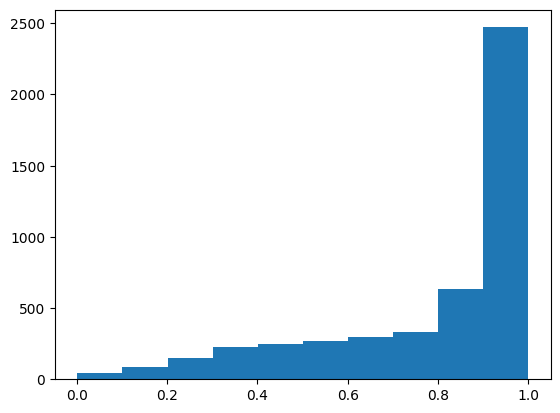

In [11]:
plt.hist(nonzero_iou.numpy(), bins=10);

In [12]:
duplicate_idx = set()
iou_threshold = 0.5
distance_threshold = 40

for current in tqdm(range(len(df))):
    if current in duplicate_idx:
        continue
    for idx in np.argsort(distances[current]):
        if distances[current, idx] > distance_threshold:
            break
        if idx == current:
            continue
        else:
            if iou[current, idx] > iou_threshold:
                duplicate_idx.add(idx)

  0%|          | 0/7652 [00:00<?, ?it/s]

In [13]:
len(duplicate_idx), len(df)

(1666, 7652)

### Verification

In [14]:
unique_df = df.iloc[~df.index.isin(list(duplicate_idx))]

unique_boxes = unique_df[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']].values

unique_iou = box_iou(torch.tensor(unique_boxes), torch.tensor(unique_boxes))
unique_iou.fill_diagonal_(0)

a = unique_iou.ravel()
a.sort()
a.max(), a.min()

(tensor(0.5000, dtype=torch.float64), tensor(0., dtype=torch.float64))

In [15]:
unique_df.shape

(5986, 18)

In [16]:
unique_df.head(2)

,parent,line_id,class,lat,lon,state,x_c,y_c,w,h,top_left_x,top_left_y,bottom_right_x,bottom_right_y,local_top_left_x,local_top_left_y,local_bottom_right_x,local_bottom_right_y
0,"25.08,89.00",0,zigzag,25.080005,88.998823,bangladesh,2.507251e+07,1.436115e+07,0.045432,0.068813,2.507248e+07,1.436111e+07,2.507253e+07,1.436119e+07,424.828152,520.904496,475.712328,597.975504
1,"25.08,89.00",1,zigzag,25.085225,89.002465,bangladesh,2.507285e+07,1.436061e+07,0.070036,0.039814,2.507281e+07,1.436059e+07,2.507289e+07,1.436064e+07,750.499624,0.000056,828.940056,44.591176


In [17]:
save_path = join(save_dir, f"{state}.csv")
unique_df.to_csv(save_path, index=False)
print(f"Saved at {save_path}")

Saved at /home/patel_zeel/compass24/exact_latlon/bangladesh.csv


## Statistics

In [9]:
stats = {state: [pd.read_csv(join(save_dir, f"{state}.csv")).shape[0]] for state in states}
df = pd.DataFrame(stats).T
df = df.rename(columns={0: "count"})
df.index.name = "state"
# add number of zigzag and fcbk
df["# of Zigzag"] = [pd.read_csv(join(save_dir, f"{state}.csv"))["class"].value_counts().get("zigzag", 0) for state in states]
df["# of FCBK"] = [pd.read_csv(join(save_dir, f"{state}.csv"))["class"].value_counts().get("fcbk", 0) for state in states]
df.sort_values("count", ascending=False, inplace=True)
# rename state names
df = df.rename(index={"punjab": "Punjab", "haryana": "Haryana", "bihar": "Bihar", "jharkhand": "Jharkhand", "madhya_pradesh": "Madhya Pradesh", "west_bengal": "West Bengal", "uttar_pradesh": "Uttar Pradesh", "himachal_pradesh": "Himachal Pradesh", "uttarakhand": "Uttarakhand", "bangladesh": "Bangladesh"})
df = df.rename(columns={"count": "Total"})

# change order
df = df[["# of Zigzag", "# of FCBK", "Total"]]

df.loc["Total"] = df.sum()
df.index.name = "State/Country"
print(df.to_markdown(numalign="right"))

| State/Country    |   # of Zigzag |   # of FCBK |   Total |
|:-----------------|--------------:|------------:|--------:|
| Uttar Pradesh    |          4174 |        3336 |    7510 |
| Bangladesh       |          5301 |         685 |    5986 |
| Bihar            |          3455 |         683 |    4138 |
| Haryana          |          2214 |         137 |    2351 |
| Punjab           |          2045 |         282 |    2327 |
| West Bengal      |          1626 |         665 |    2291 |
| Jharkhand        |            57 |         309 |     366 |
| Uttarakhand      |           164 |          69 |     233 |
| Madhya Pradesh   |            73 |         139 |     212 |
| Himachal Pradesh |           133 |          18 |     151 |
| Total            |         19242 |        6323 |   25565 |


| State/Country    |   # of Zigzag |   # of FCBK |   Total |
|:-----------------|--------------:|------------:|--------:|
| Uttar Pradesh    |          4174 |        3336 |    7510 |
| Bangladesh       |          5301 |         685 |    5986 |
| Bihar            |          3455 |         683 |    4138 |
| Haryana          |          2214 |         137 |    2351 |
| Punjab           |          2045 |         282 |    2327 |
| West Bengal      |          1626 |         665 |    2291 |
| Jharkhand        |            57 |         309 |     366 |
| Uttarakhand      |           164 |          69 |     233 |
| Madhya Pradesh   |            73 |         139 |     212 |
| Himachal Pradesh |           133 |          18 |     151 |
| Total            |         19242 |        6323 |   25565 |

In [20]:
import geopandas as gpd
gdf = gpd.read_file("/home/patel_zeel/India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp").to_crs(epsg=4326)

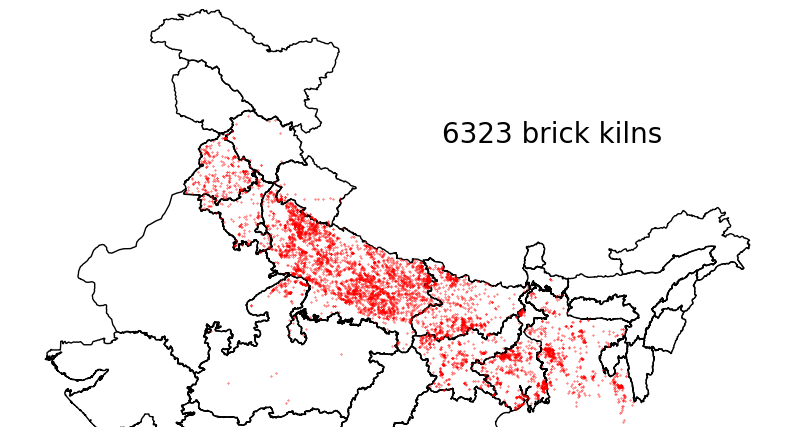

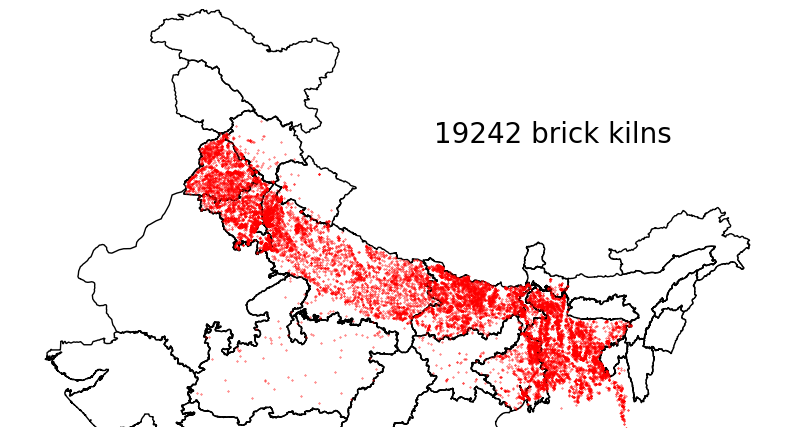

In [21]:
for class_name in ["fcbk", "zigzag"]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(ax=ax, color='none', edgecolor='black')

    data = pd.concat([pd.read_csv(join(save_dir, f"{state}.csv")) for state in states])
    tmp_data = data[data['class'] == class_name]
    
    ax.scatter(tmp_data['lon'], tmp_data['lat'], s=0.1, color='red')
    # ax.set_xlim(68, 80)
    ax.set_ylim(21, 37.1)
    ax.set_axis_off()
    # plt.legend()
    plt.text(0.7, 0.7, f"{tmp_data.shape[0]} brick kilns", fontsize=20, ha='center', va='center', transform=ax.transAxes)

    plt.savefig(f"/home/patel_zeel/kdd24_brick_kilns/images/ig_plain_bk_{class_name}.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [22]:
data['class'].value_counts() / data.shape[0]

zigzag    0.75267
fcbk      0.24733
Name: class, dtype: float64

In [23]:
data['state'].value_counts()

uttar_pradesh       7510
bangladesh          5986
bihar               4138
haryana             2351
punjab              2327
west_bengal         2291
jharkhand            366
uttarakhand          233
madhya_pradesh       212
himachal_pradesh     151
Name: state, dtype: int64

In [47]:
data.to_csv("/tmp/zbk.csv", index=False)

In [7]:
import pandas as pd
factors = {"FCBK": {"PM2.5": 6.8, "PM10": 9.7, "SO2": 4.6, "NOx": 4.7, "CO": 90.0, "CO2": 520, "BC": 2.8}}
factors["Zigzag"] = {k: 0.6*v for k, v in factors["FCBK"].items()}
factors["Hoffman"] = {k: 0.1*v for k, v in factors["FCBK"].items()}

for col in factors["FCBK"].keys():
    factors["FCBK"][col] = f"{factors['FCBK'][col]:.2f}"
    factors["Zigzag"][col] = f"{factors['Zigzag'][col]:.2f}"
    factors["Hoffman"][col] = f"{factors['Hoffman'][col]:.2f}"

print(pd.DataFrame(factors).T.to_markdown())

|         |   PM2.5 |   PM10 |   SO2 |   NOx |   CO |   CO2 |   BC |
|:--------|--------:|-------:|------:|------:|-----:|------:|-----:|
| FCBK    |    6.8  |   9.7  |  4.6  |  4.7  |   90 |   520 | 2.8  |
| Zigzag  |    4.08 |   5.82 |  2.76 |  2.82 |   54 |   312 | 1.68 |
| Hoffman |    0.68 |   0.97 |  0.46 |  0.47 |    9 |    52 | 0.28 |


In [52]:
# 6.8 for PM2.5, 9.7 for PM10, 4.6 for SO2, 4.7 for NOx, 90.0 for CO, 520 for CO2, and 2.8 for black carbon (BC).
factors = {"PM2.5": 6.8, "PM10": 9.7, "SO2": 4.6, "NOx": 4.7, "CO": 90.0, "CO2": 520, "BC": 2.8}

per_kiln_bricks = 30000
fcbk_mul = 1.0
zigzag_mul = 0.6

emissions = pd.DataFrame()

for factor in factors:
    emission_fcbk = data[data['class'] == "fcbk"]['state'].value_counts() * per_kiln_bricks * fcbk_mul * factors[factor] / 1e6
    # print(emission_fcbk)
    emission_zigzag = data[data['class'] == "zigzag"]['state'].value_counts() * per_kiln_bricks * zigzag_mul * factors[factor] / 1e6
    emissions[factor] = emission_fcbk + emission_zigzag

emissions['Total'] = emissions.sum(axis=1)
emissions.loc["Total"] = emissions.sum()

for col in emissions:
    emissions[col] = emissions[col].apply(lambda x: f"{x:.2f}")
    
# change state names
emissions = emissions.rename(index={"punjab": "Punjab", "haryana": "Haryana", "bihar": "Bihar", "jharkhand": "Jharkhand", "madhya_pradesh": "Madhya Pradesh", "west_bengal": "West Bengal", "uttar_pradesh": "Uttar Pradesh", "himachal_pradesh": "Himachal Pradesh", "uttarakhand": "Uttarakhand"})

print(emissions.to_markdown())

|                  |   PM2.5 |    PM10 |     SO2 |     NOx |       CO |       CO2 |      BC |     Total |
|:-----------------|--------:|--------:|--------:|--------:|---------:|----------:|--------:|----------:|
| Bihar            |  562.22 |  802    |  380.33 |  388.6  |  7441.2  |  42993.6  |  231.5  |  52799.4  |
| Haryana          |  298.94 |  426.43 |  202.23 |  206.62 |  3956.58 |  22860.2  |  123.09 |  28074.1  |
| Himachal Pradesh |   19.95 |   28.46 |   13.5  |   13.79 |   264.06 |   1525.68 |    8.22 |   1873.65 |
| Jharkhand        |   70.01 |   99.87 |   47.36 |   48.39 |   926.64 |   5353.92 |   28.83 |   6575.03 |
| Madhya Pradesh   |   37.29 |   53.19 |   25.23 |   25.77 |   493.56 |   2851.68 |   15.36 |   3502.08 |
| Punjab           |  307.84 |  439.12 |  208.24 |  212.77 |  4074.3  |  23540.4  |  126.76 |  28909.4  |
| Uttar Pradesh    | 1191.44 | 1699.56 |  805.98 |  823.5  | 15769.1  |  91110.2  |  490.59 | 111890    |
| Uttarakhand      |   34.15 |   48.71 |   23.

In [49]:
for per_kiln_bricks in [15000, 30000]:

    emissions = pd.DataFrame()

    for factor in factors:
        emissions[factor] = factors[factor] * data.state.value_counts() * per_kiln_bricks / 1000 / 1000 * 0.6

    emissions['Total'] = emissions.sum(axis=1)
    emissions.loc["Total"] = emissions.sum()
    
    # state names
    emissions = emissions.rename(index={"punjab": "Punjab", "haryana": "Haryana", "bihar": "Bihar", "jharkhand": "Jharkhand", "madhya_pradesh": "Madhya Pradesh", "west_bengal": "West Bengal", "uttar_pradesh": "Uttar Pradesh", "himachal_pradesh": "Himachal Pradesh", "uttarakhand": "Uttarakhand"})

    print(emissions.to_markdown())

|                  |     PM2.5 |      PM10 |      SO2 |      NOx |       CO |      CO2 |       BC |      Total |
|:-----------------|----------:|----------:|---------:|---------:|---------:|---------:|---------:|-----------:|
| Uttar Pradesh    |  459.612  |  655.623  | 310.914  | 317.673  |  6083.1  | 35146.8  | 189.252  |  43163     |
| Bihar            |  253.246  |  361.247  | 171.313  | 175.037  |  3351.78 | 19365.8  | 104.278  |  23782.7   |
| Haryana          |  143.881  |  205.242  |  97.3314 |  99.4473 |  1904.31 | 11002.7  |  59.2452 |  13512.1   |
| Punjab           |  142.412  |  203.147  |  96.3378 |  98.4321 |  1884.87 | 10890.4  |  58.6404 |  13374.2   |
| West Bengal      |  140.209  |  200.004  |  94.8474 |  96.9093 |  1855.71 | 10721.9  |  57.7332 |  13167.3   |
| Jharkhand        |   22.3992 |   31.9518 |  15.1524 |  15.4818 |   296.46 |  1712.88 |   9.2232 |   2103.55  |
| Uttarakhand      |   14.2596 |   20.3409 |   9.6462 |   9.8559 |   188.73 |  1090.44 |   5.871

In [50]:
for per_kiln_bricks in [15000, 30000]:

    emissions = pd.DataFrame()

    for factor in factors:
        emissions[factor] = factors[factor] * data.state.value_counts() * per_kiln_bricks / 1000 / 1000 * 0.1

    emissions['Total'] = emissions.sum(axis=1)
    emissions.loc["Total"] = emissions.sum()

    print(emissions.to_markdown())

|                  |    PM2.5 |      PM10 |      SO2 |       NOx |       CO |      CO2 |      BC |     Total |
|:-----------------|---------:|----------:|---------:|----------:|---------:|---------:|--------:|----------:|
| uttar_pradesh    |  76.602  | 109.27    |  51.819  |  52.9455  | 1013.85  |  5857.8  | 31.542  |  7193.83  |
| bihar            |  42.2076 |  60.2079  |  28.5522 |  29.1729  |  558.63  |  3227.64 | 17.3796 |  3963.79  |
| haryana          |  23.9802 |  34.207   |  16.2219 |  16.5745  |  317.385 |  1833.78 |  9.8742 |  2252.02  |
| punjab           |  23.7354 |  33.8578  |  16.0563 |  16.4054  |  314.145 |  1815.06 |  9.7734 |  2229.03  |
| west_bengal      |  23.3682 |  33.334   |  15.8079 |  16.1516  |  309.285 |  1786.98 |  9.6222 |  2194.55  |
| jharkhand        |   3.7332 |   5.3253  |   2.5254 |   2.5803  |   49.41  |   285.48 |  1.5372 |   350.591 |
| uttarakhand      |   2.3766 |   3.39015 |   1.6077 |   1.64265 |   31.455 |   181.74 |  0.9786 |   223.191 |
|

In [51]:
(1428-1198)/1428

0.16106442577030813